# 주차수요 예측 AI 경진대회

🏠 유형별 임대주택 설계 시 단지 내 적정 🅿️ 주차 수요를 예측   
신규 건축예정 부지 인근의 유사 단지를 피크 시간대 방문하여 주차된 차량대수를 세는 방법으로 조사

In [1]:
# 라이브러리
import numpy as np
import pandas as pd

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic') # 윈도우 한글

# 경고
import warnings
warnings.filterwarnings(action='ignore')

[ 데이터 ] 
- age_gender_info.csv - 지역 임대주택 나이별, 성별 인구 분포

In [2]:
# 데이터 불러오기
age_gender = pd.read_csv('data/age_gender_info.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

※ 동일한 단지에 코드가 2개로 부여된 단지 코드 (3쌍) : ['C2085', **'C1397'**], ['C2431', **'C1649'**], ['C1036', 'C2675']   
ㄴ 단지코드가 낮은걸로 통일

In [3]:
# 동일한 단지에 코드가 2개로 부여된 단지 코드
train['단지코드'][train['단지코드'].isin(['C2085', 'C1397'])] = 'C1397'
train['총세대수'][train['단지코드']=='C1397'] = 1339
train['공가수'][train['단지코드']=='C1397'] = 9

train['단지코드'][train['단지코드'].isin(['C2431', 'C1649'])] = 'C1649'
train['총세대수'][train['단지코드']=='C1649'] = 1047
train['등록차량수'][train['단지코드']=='C1649'] = 1214
train['공가수'][train['단지코드']=='C1649'] = 31
train['도보 10분거리 내 버스정류장 수'][train['단지코드']=='C1649'] = 2


train['총세대수'][train['단지코드']=='C1036'] = 1254

# 데이터 오류인 단지코드 제외
train = train[~train['단지코드'].isin(['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])].reset_index(drop = True)

# Ⅰ.데이터 살펴보기

In [4]:
age_gender.head(2)

,지역,10대미만(여자),10대미만(남자),10대(여자),10대(남자),20대(여자),20대(남자),30대(여자),30대(남자),40대(여자),...,60대(여자),60대(남자),70대(여자),70대(남자),80대(여자),80대(남자),90대(여자),90대(남자),100대(여자),100대(남자)
0,경상북도,0.030158,0.033195,0.056346,0.061360,0.060096,0.067859,0.053433,0.049572,0.083660,...,0.082684,0.063889,0.047717,0.030172,0.029361,0.011211,0.005578,0.001553,0.000234,0.000014
1,경상남도,0.027400,0.026902,0.053257,0.055568,0.064920,0.070618,0.056414,0.057550,0.077092,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010


In [5]:
train.head(2)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,0.0,3.0,624.0,205.0
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17.0,A,12672000,107130,0.0,3.0,624.0,205.0


In [6]:
test.head(2)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000,189840,0.0,2.0,683.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000,249930,0.0,2.0,683.0


In [7]:
# 데이터 정보
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2896 non-null   object 
 1   총세대수                          2896 non-null   int64  
 2   임대건물구분                        2896 non-null   object 
 3   지역                            2896 non-null   object 
 4   공급유형                          2896 non-null   object 
 5   전용면적                          2896 non-null   float64
 6   전용면적별세대수                      2896 non-null   int64  
 7   공가수                           2896 non-null   float64
 8   자격유형                          2896 non-null   object 
 9   임대보증금                         2327 non-null   object 
 10  임대료                           2327 non-null   object 
 11  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2685 non-null   float64
 12  도보 10분거리 내 버스정류장 수            2896 non-null   float64
 13  단지내

ㄴ 임대보증금, 임대료 열은 금액을 나타내지만 데이터 형식이 object이다. 데이터에 수치형이 아닌 것이 포함되어 있는지 확인해볼 필요가 있다.   
ㄴ 일부 열에서 결측값이 존재한다.    

In [8]:
# 기초통계
train.describe(include='all')

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
count,2896,2896.000000,2896,2896,2896,2896.000000,2896.000000,2896.000000,2896,2327,2327,2685.000000,2896.000000,2896.000000,2896.000000
unique,414,NaN,2,16,10,NaN,NaN,NaN,15,938,975,NaN,NaN,NaN,NaN
top,C1439,NaN,아파트,경기도,국민임대,NaN,NaN,NaN,A,24775000,-,NaN,NaN,NaN,NaN
freq,48,NaN,2334,602,1736,NaN,NaN,NaN,1756,22,21,NaN,NaN,NaN,NaN
mean,NaN,891.051796,NaN,NaN,NaN,44.559033,102.822514,12.934738,NaN,NaN,NaN,0.180261,3.700967,598.766575,558.315953
std,NaN,516.683612,NaN,NaN,NaN,32.000640,132.988590,10.665306,NaN,NaN,NaN,0.431074,2.665784,396.677644,437.015694
min,NaN,26.000000,NaN,NaN,NaN,12.620000,1.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,13.000000,13.000000
25%,NaN,514.000000,NaN,NaN,NaN,32.100000,14.750000,4.000000,NaN,NaN,NaN,0.000000,2.000000,277.000000,209.000000
50%,NaN,780.000000,NaN,NaN,NaN,39.905000,60.000000,11.000000,NaN,NaN,NaN,0.000000,3.000000,507.000000,481.000000
75%,NaN,1106.000000,NaN,NaN,NaN,51.292500,143.250000,20.000000,NaN,NaN,NaN,0.000000,4.000000,823.000000,763.000000


ㄴ 지하철역 수는 대부분 0이다.    

In [9]:
# 상관계수
train.corr()

,총세대수,전용면적,전용면적별세대수,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
총세대수,1.000000,0.040105,0.098874,0.069111,0.211761,-0.003052,0.522629,0.333513
전용면적,0.040105,1.000000,-0.032453,-0.077093,-0.010291,-0.006110,0.067340,0.112717
전용면적별세대수,0.098874,-0.032453,1.000000,0.163816,-0.057606,0.045094,0.283585,0.250513
공가수,0.069111,-0.077093,0.163816,1.000000,-0.095688,0.041144,0.297161,0.128880
도보 10분거리 내 지하철역 수(환승노선 수 반영),0.211761,-0.010291,-0.057606,-0.095688,1.000000,0.097503,-0.053185,-0.107308
도보 10분거리 내 버스정류장 수,-0.003052,-0.006110,0.045094,0.041144,0.097503,1.000000,0.071882,0.102619
단지내주차면수,0.522629,0.067340,0.283585,0.297161,-0.053185,0.071882,1.000000,0.861338
등록차량수,0.333513,0.112717,0.250513,0.128880,-0.107308,0.102619,0.861338,1.000000


ㄴ **단지내주차면수 ~ 등록차량수**가 양의 상관관계이다.

In [10]:
# object 열의 값 알아보기
for c in train.columns:
    if train[c].dtypes == 'object' and c not in ('단지코드', '임대보증금', '임대료'):
        print(f'-- {c} --')
        print(train[['단지코드', c]].drop_duplicates()[c].value_counts(), '\n')

-- 임대건물구분 --
아파트    414
상가      33
Name: 임대건물구분, dtype: int64 

-- 지역 --
경기도        85
경상남도       54
강원도        37
충청북도       30
부산광역시      25
대전광역시      25
전라남도       24
광주광역시      24
전라북도       21
경상북도       21
충청남도       19
대구광역시      18
제주특별자치도    14
서울특별시       7
울산광역시       7
세종특별자치시     3
Name: 지역, dtype: int64 

-- 공급유형 --
국민임대         309
영구임대          56
공공임대(10년)     36
임대상가          33
행복주택          29
공공임대(50년)     11
공공임대(분납)       3
장기전세           2
공공분양           1
공공임대(5년)       1
Name: 공급유형, dtype: int64 

-- 자격유형 --
A    325
C     36
D     34
H     32
I     19
J     17
E     16
L      6
K      5
B      3
N      3
G      2
M      1
O      1
F      1
Name: 자격유형, dtype: int64 



ㄴ 공급유형 : 공공분양, 공공임대(5년)은 값이 1이다.   
ㄴ 자격유형의 데이터 불균형도 심하다.

#### '등록차량수' 열 살펴보기   

skew : 1.4643673134520783


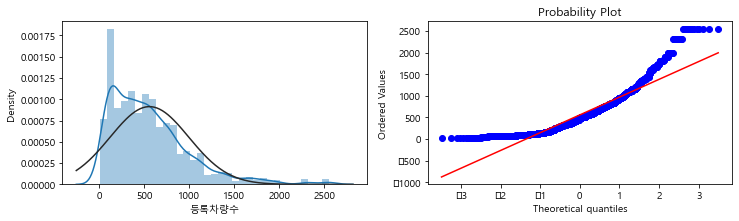

In [11]:
# 히스토그램
plt.figure(figsize = (12, 3))
plt.subplot(121)
sns.distplot(train['등록차량수'] , fit=norm)
print('skew :', stats.skew(train['등록차량수']))

# Q-Q Plot
plt.subplot(122)
stats.probplot(train['등록차량수'], plot=plt)
plt.show()

ㄴ 예측대상인 '등록차량수'열이 오른쪽으로 치우쳐져있다. 회귀 모델링을 하기 위해서 데이터를 정규분포로 변환하는 것이 좋다. 

boxcox transformation : -0.05
sqrt-skew : 0.43


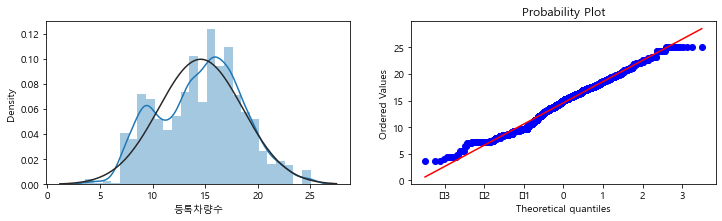

In [12]:
# 정규화
print('boxcox transformation :', round(stats.skew(stats.boxcox(train['등록차량수'])[0]), 2))
print('sqrt-skew :', round(stats.skew(np.sqrt(train["등록차량수"])), 2))

# Box-Cox
train['등록차량수'], lmb = stats.boxcox(train['등록차량수'])


# 히스토그램
plt.figure(figsize = (12, 3))
plt.subplot(121)
sns.distplot(train['등록차량수'], fit=norm)

# Q-Q Plot
plt.subplot(122)
stats.probplot(train['등록차량수'], plot=plt)
plt.show()

ㄴ Box-Cox로 '등록차량수'를 정규분포의 형태로 변형해준다.

지역별/공급유형별 등록차량수의 분포

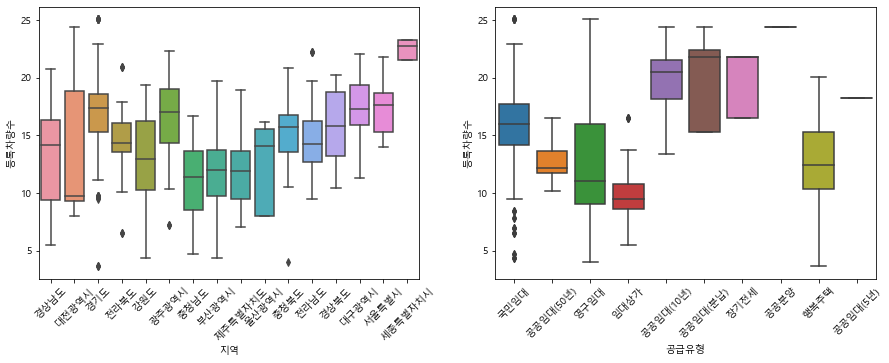

In [13]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
sns.boxplot(x = '지역', y = '등록차량수', data = train)
plt.xticks(rotation=45)
plt.subplot(122)
sns.boxplot(x = '공급유형', y = '등록차량수', data = train)
plt.xticks(rotation=45)
plt.show()

ㄴ 일부 지역에서 outlier 존재 > RobustScaler로 스케일링해준다.

Q. 같은 단지이면 동일한 등록차량수 인가?

In [14]:
train[['단지코드', '등록차량수']].drop_duplicates()['단지코드'].value_counts()

C1004    1
C1263    1
C2518    1
C1497    1
C2570    1
        ..
C2059    1
C2326    1
C2351    1
C1970    1
C2038    1
Name: 단지코드, Length: 414, dtype: int64

A. 같은 단지면 동일한 등록차량수를 가진다.

Q. 같은 단지지만 2개 이상의 임대건물구분이 존재하는가?

In [15]:
a_code = train[['단지코드', '임대건물구분']].drop_duplicates()['단지코드'].value_counts()
a_code_counts = pd.DataFrame({'단지코드':a_code.index, '카운트':a_code.values})
a_code_counts = pd.merge(train[['단지코드', '임대건물구분']].drop_duplicates(), a_code_counts, how = 'left', on = '단지코드')
a_code_counts[a_code_counts['카운트']==2]

,단지코드,임대건물구분,카운트
12,C1925,아파트,2
13,C1925,상가,2
16,C1874,아파트,2
17,C1874,상가,2
19,C2416,아파트,2
...,...,...,...
97,C1875,상가,2
99,C2212,아파트,2
100,C2212,상가,2
102,C2571,아파트,2


In [16]:
train[train['단지코드']=='C2416']

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
123,C2416,560,아파트,경상남도,영구임대,26.34,360,0.0,C,3138000,69820,0.0,5.0,154.0,7.358019
124,C2416,560,아파트,경상남도,영구임대,30.48,192,0.0,C,3631000,80800,0.0,5.0,154.0,7.358019
125,C2416,560,상가,경상남도,임대상가,19.69,1,0.0,D,NaN,NaN,0.0,5.0,154.0,7.358019
126,C2416,560,상가,경상남도,임대상가,27.12,1,0.0,D,NaN,NaN,0.0,5.0,154.0,7.358019
127,C2416,560,상가,경상남도,임대상가,32.54,1,0.0,D,NaN,NaN,0.0,5.0,154.0,7.358019
128,C2416,560,상가,경상남도,임대상가,36.43,1,0.0,D,NaN,NaN,0.0,5.0,154.0,7.358019
129,C2416,560,상가,경상남도,임대상가,46.89,1,0.0,D,NaN,NaN,0.0,5.0,154.0,7.358019
130,C2416,560,상가,경상남도,임대상가,49.99,1,0.0,D,NaN,NaN,0.0,5.0,154.0,7.358019
131,C2416,560,상가,경상남도,임대상가,51.14,1,0.0,D,NaN,NaN,0.0,5.0,154.0,7.358019
132,C2416,560,상가,경상남도,임대상가,317.17,1,0.0,D,NaN,NaN,0.0,5.0,154.0,7.358019


ㄴ '상가'의 임대보증금과 임대료가 누락되어있다.

A. 존재한다.

Q. 상가만 단독으로 있는 단지가 있나?

In [17]:
a_code_counts[(a_code_counts['카운트']==1) & (a_code_counts['임대건물구분']=='상가')]

,단지코드,임대건물구분,카운트


A. 없다.

In [18]:
set(train[train['임대건물구분']=='상가']['공급유형'])

{'임대상가'}

✔ 공급유형으로 구분이 가능하기에 '임대건물구분'이 '상가'인 것은 제외한다.

In [19]:
# '임대건물구분' 열은 필요없어졌으므로 삭제
train.drop(['임대건물구분'], axis = 1, inplace = True)
test.drop(['임대건물구분'], axis = 1, inplace = True)

---
# Ⅱ.데이터 처리

In [20]:
# 열 이름 변경
train.rename(columns = {'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철',
                        '도보 10분거리 내 버스정류장 수':'버스'}, inplace=True)
test.rename(columns = {'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철',
                        '도보 10분거리 내 버스정류장 수':'버스'}, inplace=True)

In [21]:
# 중복 제거
train = train.drop_duplicates().reset_index(drop = True)
test = test.drop_duplicates().reset_index(drop = True)

## 1. 임대보증금 / 임대료 열이 object

In [22]:
# 숫자가 아닌 값이 무엇이 있는지 확인
train['임대보증금'].apply(lambda x: x if (pd.isnull(x) == True) or x.isdigit() == False else '숫자').unique()

array(['숫자', nan, '-'], dtype=object)

In [23]:
# 숫자가 아닌 값이 무엇이 있는지 확인
train['임대료'].apply(lambda x: x if (pd.isnull(x) == True) or x.isdigit() == False else '숫자').unique()

array(['숫자', nan, '-'], dtype=object)

ㄴ 결측값으로 '-', nan 둘 다 존재한다. 

### 값 채우기

1) 임대보증금이 있지만, 임대료는 '-'인 경우

In [24]:
temp = train[(train['임대보증금']!='-')&(train['임대료']!='-')][['임대보증금', '임대료']]
temp = temp[(temp['임대보증금'].notnull())&(temp['임대료'].notnull())]
temp = temp.astype(int)
temp['값'] = round(temp['임대료']/temp['임대보증금'], 2)
temp['값'].value_counts()

0.01    1908
0.00     203
0.02     152
Name: 값, dtype: int64

In [25]:
np.mean(temp['값'])

0.009774635439682017

대체로 임대보증금의 0.01% 가 임대료이다. 임대료가 '-' 인 것 중에서 임대보증금이 있는 것은 '임대보증금*0.01=임대료'로 계산하여 값을 구한다. 

In [26]:
# '-'의 임대료 구하기
for i in range(len(train)):
    if train['임대료'][i] == '-' and train['임대보증금'][i]!='-':
        train['임대료'][i] = round(int(train['임대보증금'][i])*0.01)

2) 임대보증금, 임대료가 nan   
: nan인 경우 둘 다 없는 것이다.
- train 데이터에서 nan인 행 :   
    1) '상가'가 아닐 때 : '공급유형'이 '공공분양'인 경우이다. 이는 outlier에 해당하므로 제거해준다.   
    2) '상가'일 때 : 0으로 대치한다.
- test 데이터에서 nan인 행 :   
    1) '상가'가 아닐 때 : 동일한 단지코드의 값을 입력한다.   
    2) '상가'일 때 : 0으로 대치한다.

In [27]:
# total[total['임대료'].isnull()]
# total[total['임대보증금'].isnull()]
# set(total[total['임대료'].isnull()].index) - set(total[total['임대보증금'].isnull()].index)

In [28]:
# train
train = train[train['공급유형']!='공공분양'].reset_index(drop = True) # 공공분양
train[['임대료', '임대보증금']] = train[['임대료', '임대보증금']].fillna(0) # 상가

In [29]:
# test
test['임대보증금'][(test['단지코드']=='C1006')&(test['공급유형']!='임대상가')&(test['전용면적']==26.37)&(test['임대보증금'].isnull())] = 5787000
test['임대료'][(test['단지코드']=='C1006')&(test['공급유형']!='임대상가')&(test['전용면적']==26.37)&(test['임대료'].isnull())] = 79980

test['임대보증금'][(test['단지코드']=='C1006')&(test['공급유형']!='임대상가')&(test['전용면적']==52.74)&(test['임대보증금'].isnull())] = 6873000
test['임대료'][(test['단지코드']=='C1006')&(test['공급유형']!='임대상가')&(test['전용면적']==52.74)&(test['임대료'].isnull())] = 94990

# test 상가
test[['임대료', '임대보증금']] = test[['임대료', '임대보증금']].fillna(0)

3) 임대보증금, 임대료가 '-'   
평균으로 대치한다.

In [30]:
#np.mean(train['임대료'][(train['공급유형']!='임대상가')&(train['임대보증금']!='-')].astype(int))

# 전체평균
train['임대보증금'][train['임대보증금']=='-'] = 26544524
train['임대료'][train['임대료']=='-'] = 198874
test['임대보증금'][test['임대보증금']=='-'] = 26544524
test['임대료'][test['임대료']=='-'] = 198874

### 데이터타입을 수치형으로 변경

In [31]:
train[['임대료', '임대보증금']] = train[['임대료', '임대보증금']].astype(int)
test[['임대료', '임대보증금']] = test[['임대료', '임대보증금']].astype(int)

---  

## 2. 결측값

In [32]:
train.isnull().sum()

단지코드          0
총세대수          0
지역            0
공급유형          0
전용면적          0
전용면적별세대수      0
공가수           0
자격유형          0
임대보증금         0
임대료           0
지하철         148
버스            0
단지내주차면수       0
등록차량수         0
dtype: int64

In [33]:
test.isnull().sum()

단지코드         0
총세대수         0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
자격유형         2
임대보증금        0
임대료          0
지하철         34
버스           0
단지내주차면수      0
dtype: int64

ㄴ '지하철' 열에 결측값이 있다.   
- 지하철 : 삼분위수까지 값이 0이었으므로 결측값을 0으로 채운다.   
- test데이터의 단지코드 : 같은 단지코드의 자격유형으로 채운다.   

In [34]:
# 도보10분내...
train['지하철'] = train['지하철'].fillna(0)
test['지하철'] = test['지하철'].fillna(0)

# test 단지코드
test.loc[test['단지코드'].isin(['C2411']) & test['자격유형'].isnull(), '자격유형'] = 'A'
test.loc[test['단지코드'].isin(['C2253']) & test['자격유형'].isnull(), '자격유형'] = 'C'

## 3. 파생변수 생성

In [35]:
# 대중교통 열 생성
train['대중교통'] = train['지하철'] + train['버스']
train.drop(['지하철', '버스'], axis = 1, inplace = True)

test['대중교통'] = test['지하철'] + test['버스']
test.drop(['지하철', '버스'], axis = 1, inplace = True)

{'whiskers': [<matplotlib.lines.Line2D at 0x26216bd2640>,
 'caps': [<matplotlib.lines.Line2D at 0x26216bd2d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x26216bd22e0>],
 'medians': [<matplotlib.lines.Line2D at 0x26216bde400>],
 'fliers': [<matplotlib.lines.Line2D at 0x26216bde760>],
 'means': []}

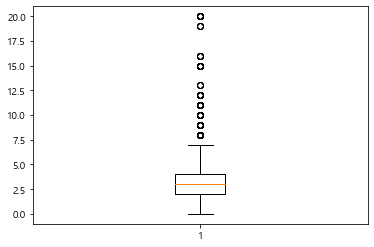

In [36]:
plt.boxplot(train['대중교통'])

### 단지코드와 1:N의 관계인 열
공급유형 / 자격유형 / 전용면적 / 전용면적별세대수 > 전체 합하면 단지별 총세대수 / 임대보증금 / 임대료   

1) 공급유형 & 자격유형

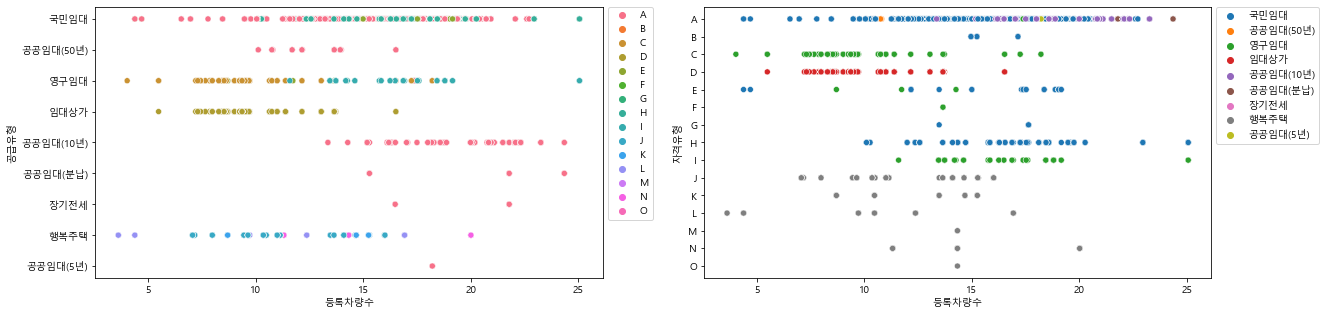

In [37]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.scatterplot(x='등록차량수', y='공급유형', hue='자격유형', data = train) #train[train['자격유형']=='A']
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.subplot(122)
sns.scatterplot(x='등록차량수', y='자격유형', hue='공급유형', data = train) #train[train['자격유형']=='A']
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
plt.show()

비슷한 것끼리 묶기

In [38]:
# 공급유형
train.loc[train['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)', '장기전세']), '공급유형'] = '공공임대(5년/10년/분납)+장기전세'
train.loc[train['공급유형'].isin(['영구임대', '행복주택']), '공급유형'] = '영구임대+행복주택'#
test.loc[test['공급유형'].isin(['공공임대(5년)', '공공임대(10년)', '공공임대(분납)', '장기전세']), '공급유형'] = '공공임대(5년/10년/분납)+장기전세'
test.loc[test['공급유형'].isin(['영구임대', '행복주택']), '공급유형'] = '영구임대+행복주택'#


# 자격유형
train.loc[train['자격유형'].isin(['C', 'D']), '자격유형'] = 'CD'
train.loc[train['자격유형'].isin(['B', 'E', 'F', 'G']), '자격유형'] = 'BEFG' #
train.loc[train['자격유형'].isin(['H', 'I']), '자격유형'] = 'HI'
train.loc[train['자격유형'].isin(['J', 'K', 'L', 'M', 'N', 'O']), '자격유형'] = '행복주택_공급대상' #

test.loc[test['자격유형'].isin(['C', 'D']), '자격유형'] = 'CD'
test.loc[test['자격유형'].isin(['B', 'E', 'F', 'G']), '자격유형'] = 'BEFG'
test.loc[test['자격유형'].isin(['H', 'I']), '자격유형'] = 'HI'
test.loc[test['자격유형'].isin(['J', 'K', 'L', 'M', 'N', 'O']), '자격유형'] = '행복주택_공급대상'

2) 전용면적 * 전용면적별세대수 = 면적   

In [39]:
train['면적'] = train['전용면적']*train['전용면적별세대수']
test['면적'] = test['전용면적']*test['전용면적별세대수']

### 3. 데이터 합치기

In [40]:
train.head(2)

,단지코드,총세대수,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,단지내주차면수,등록차량수,대중교통,면적
0,C2515,545,경상남도,국민임대,33.48,276,17.0,A,9216000,82940,624.0,11.317535,3.0,9240.48
1,C2515,545,경상남도,국민임대,39.60,60,17.0,A,12672000,107130,624.0,11.317535,3.0,2376.00


### age_gender

In [41]:
age_gender['미성년자'] = age_gender['10대미만(여자)'] + age_gender['10대미만(남자)'] + age_gender['10대(남자)'] + age_gender['10대(여자)']
age_gender['성인'] = age_gender[['20대(여자)', '20대(남자)', '30대(여자)', '30대(남자)', '40대(여자)', '40대(남자)', '50대(여자)', '50대(남자)', 
                                 '60대(여자)', '60대(남자)', '70대(여자)', '70대(남자)', '80대(여자)', '80대(남자)', '90대(여자)', '90대(남자)', 
                                 '100대(여자)', '100대(남자)']].apply(lambda x: x.sum(), axis = 1)

In [42]:
train = pd.merge(train, age_gender[['지역', '미성년자', '성인']], on = '지역', how = 'left')
test = pd.merge(test, age_gender[['지역', '미성년자', '성인']], on = '지역', how = 'left')

### 단지코드 통합

In [43]:
# train
train_g = train.groupby(['단지코드', '총세대수', '공가수', '대중교통', '단지내주차면수', '미성년자', '성인', '등록차량수'], as_index = False, dropna = False)['임대보증금', '임대료', '면적'].sum()
train_g.rename(columns = {'임대보증금':'임대보증금_sum', '임대료':'임대료_sum', '면적':'면적_sum'}, inplace = True)
mean_g = train.groupby(['단지코드', '총세대수', '공가수', '대중교통', '단지내주차면수', '미성년자', '성인', '등록차량수'], as_index = False, dropna = False).mean()[['단지코드', '임대보증금', '임대료', '면적']]
mean_g.rename(columns = {'임대보증금':'임대보증금_mean', '임대료':'임대료_mean', '면적':'면적_mean'}, inplace = True)

train_g = pd.merge(train_g, mean_g, on = '단지코드', how = 'left')

###

# test
test_g = test.groupby(['단지코드', '총세대수', '공가수', '대중교통', '단지내주차면수', '미성년자', '성인'], as_index = False, dropna = False)['임대보증금', '임대료', '면적'].sum()
test_g.rename(columns = {'임대보증금':'임대보증금_sum', '임대료':'임대료_sum', '면적':'면적_sum'}, inplace = True)
mean_g = test.groupby(['단지코드', '총세대수', '공가수', '대중교통', '단지내주차면수', '미성년자', '성인'], as_index = False, dropna = False).mean()[['단지코드', '임대보증금', '임대료', '면적']]
mean_g.rename(columns = {'임대보증금':'임대보증금_mean', '임대료':'임대료_mean', '면적':'면적_mean'}, inplace = True)

test_g = pd.merge(test_g, mean_g, on = '단지코드', how = 'left')

### 4. Encoding & Scaling

In [44]:
# Encoding
def get_dum(col, df, df_g):
    str_val = df[['단지코드', col]].drop_duplicates()
    str_val = pd.get_dummies(str_val, columns = [col])
    str_val = str_val.groupby(['단지코드'], as_index = False).sum()
    return pd.merge(df_g, str_val, on = '단지코드', how = 'left')

for c in ['지역', '공급유형', '자격유형']:
    train_g = get_dum(c, train, train_g)
    test_g = get_dum(c, test, test_g)

이상치가 포함되어 있어서 RobustScaler로 스케일링

In [45]:
# Scaling
from sklearn.preprocessing import RobustScaler

scaling_features = ['총세대수', '공가수', '대중교통', '단지내주차면수', '미성년자', '성인',
                    '임대보증금_sum', '임대료_sum', '면적_sum',
                    '임대보증금_mean', '임대료_mean', '면적_mean']

scaler = RobustScaler()
train_g.loc[:, scaling_features] = scaler.fit_transform(train_g[scaling_features])
test_g.loc[:, scaling_features] = scaler.transform(test_g[scaling_features])

---
# Ⅲ. 모델링

In [46]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Modeling
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

# Box-Cox 원복
from scipy.special import inv_boxcox

## pycaret

In [47]:
X = train_g.drop(['단지코드'], axis = 1)

In [48]:
reg = setup(X, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.999,  # 우리는 전체 데이터를 학습해 test를 예측하는게 목표이기 때문에, 0.999로 설정한다.
            target = '등록차량수', # 목표 변수는 등록 차량 수 이다.
            silent = True, # 엔터를 누르기 귀찮다. 궁금하면 풀어보세요
            use_gpu = False, # GPU가 있으면 사용하세요 (Cat Boost 속도 향상)
            numeric_features=list(X.drop(['등록차량수'], axis=1).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,등록차량수
2,Original Data,"(414, 39)"
3,Missing Values,False
4,Numeric Features,38
5,Categorical Features,0
6,Transformed Train Set,"(413, 38)"
7,Transformed Test Set,"(1, 38)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


Top5의 모델 선택

In [49]:
top5 = compare_models(n_select = 5, sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1.1529,2.6181,1.6067,0.7931,0.1156,0.0895,0.1620
et,Extra Trees Regressor,1.1548,2.7198,1.6300,0.7849,0.1160,0.0892,0.1470
catboost,CatBoost Regressor,1.1631,2.6567,1.6208,0.7893,0.1211,0.0926,1.7840
gbr,Gradient Boosting Regressor,1.2126,2.7659,1.6566,0.7811,0.1203,0.0937,0.0560
huber,Huber Regressor,1.2514,2.9871,1.7148,0.7654,0.1323,0.1028,0.0180
lightgbm,Light Gradient Boosting Machine,1.2560,2.9759,1.7149,0.7642,0.1256,0.0981,0.3650
xgboost,Extreme Gradient Boosting,1.2561,2.9906,1.7202,0.7649,0.1205,0.0944,0.3710
br,Bayesian Ridge,1.2642,2.9947,1.7144,0.7652,0.1327,0.1035,0.0090
ridge,Ridge Regression,1.2673,2.9887,1.7153,0.7658,0.1321,0.1030,0.0080
lr,Linear Regression,1.2784,3.0162,1.7255,0.7638,0.1312,0.1029,1.2130


In [50]:
# 모델의 예측력
def model_mae(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('MAE :',mean_absolute_error(y_test, y_pred))
    
# K-Fold
def kfold_mae(model):
    kfold = KFold(n_splits=5,random_state=0,shuffle=True)
    results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')*-1
    print('MAE :', np.mean(results))

---

In [51]:
X = train_g.drop(['단지코드', '등록차량수', '지역_서울특별시'], axis = 1)
y = train_g['등록차량수']

# Hold-Out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=100)

### RandomForest

In [52]:
model = RandomForestRegressor(n_estimators=1000, criterion='mae', max_depth=6,n_jobs=-1,random_state=42)
model_mae(model)

MAE : 1.3087131607235751


### ExtraTrees

In [53]:
model = ExtraTreesRegressor(n_estimators=1000, criterion='mae', max_depth=6, min_samples_split=2
                            , min_samples_leaf=1, min_weight_fraction_leaf=0.01, random_state=42)
model_mae(model)

MAE : 1.1836932716779627


변수중요도

In [54]:
model.fit(X_train, y_train)
pd.DataFrame({'col':X_train.columns, 'imp':model.feature_importances_}).sort_values(['imp'], ascending=False)

,col,imp
3,단지내주차면수,0.418887
8,면적_sum,0.257764
0,총세대수,0.074479
31,공급유형_임대상가,0.067973
32,자격유형_A,0.036794
28,공급유형_공공임대(5년/10년/분납)+장기전세,0.018574
29,공급유형_국민임대,0.015743
11,면적_mean,0.014413
9,임대보증금_mean,0.012461
34,자격유형_CD,0.011257


### CatBoostRegressor

GridSearch

In [55]:
cat = CatBoostRegressor(n_estimators=1000, verbose=False, random_state=42)
parameters = {'max_depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'colsample_bylevel' : [0.5, 0.6, 0.8]
              }

grid = GridSearchCV(estimator=cat, param_grid = parameters, cv = 3, n_jobs=-1)
grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', grid.best_params_)

Best parameters found by grid search are: {'colsample_bylevel': 0.6, 'learning_rate': 0.01, 'max_depth': 6}


In [56]:
cat = CatBoostRegressor(max_depth=6, colsample_bylevel=0.6, subsample=0.8, verbose=False, random_state=42,
                        n_estimators=1000, learning_rate = 0.01, objective='MAE', loss_function='MAE')
model_mae(cat)

MAE : 1.2656854674557707


In [57]:
# K-Fold
kfold_mae(cat)

MAE : 1.1118128420700288


## 예측하기

In [58]:
t = test_g.drop(['단지코드'], axis = 1)
t['지역_서울특별시'] = 0

# predict & boxcox 원복
test_g['num'] = inv_boxcox(cat.predict(t), lmb)

In [59]:
# sample_submission에 맞추어 내보내기
submission = pd.read_csv('data/sample_submission.csv', usecols=['code'])

pd.merge(submission, test_g[['단지코드', 'num']], 
         how = 'left', left_on = 'code', right_on = '단지코드')[['code', 'num']].to_csv('submission.csv', index = False)